In [33]:
# PCA imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [7]:
# Doc2Vec imports
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim

import json # to open our data file
DATA_FILENAME = "trend_analisys.json"
# open json file
with open(DATA_FILENAME, "r") as json_file:
    json_data = json.load(json_file)
# we're expecting a list now, since our json file is a json array
assert type(json_data) is list

True

## Version 1 - Training Model with Abstract field (whole text)

In [26]:
# we have our json data now, let's go ahead and divide into training and test set
n_examples =  len(json_data)
# how much of the data we're going to be using for training and for testing
# default values: 80% train, 20% test
TRAIN_DATA_LENGTH = 8 * n_examples // 10
TEST_DATA_LENGTH = n_examples - TRAIN_DATA_LENGTH
ABSTRACT_FIELD_NAME = 'abstract'

print("Total examples: {0}, number of train examples: {1}, number of test examples: {2}".format(n_examples,TRAIN_DATA_LENGTH, TEST_DATA_LENGTH))

# TODO: Randomize selection of examples, don't just take the first ones
# build training corpus: take the needed abstract, preprocess them (tokenize, delete spaces..)
# and create the TaggedDocument needed for training
train_corpus = [gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(dictionary[ABSTRACT_FIELD_NAME]), [i]) for i, dictionary in enumerate(json_data) if i<TRAIN_DATA_LENGTH]
assert len(train_corpus)==TRAIN_DATA_LENGTH
print(train_corpus[:1])

Total examples: 293, number of train examples: 234, number of test examples: 59
[TaggedDocument(words=['il', 'mercato', 'degli', 'smartphone', 'si', 'fa', 'ogni', 'giorno', 'più', 'ricco', 'le', 'possibilità', 'di', 'scelta', 'tra', 'prodotti', 'di', 'buon', 'ottima', 'qualità', 'prezzi', 'diversi', 'sono', 'in', 'costante', 'crescita', 'certamente', 'tra', 'gli', 'smartphone', 'che', 'vi', 'consigliamo', 'prendere', 'in', 'considerazione', 'tra', 'quelli', 'usciti', 'di', 'recente', 'il', 'thinq', 'di', 'lg', 'sottile', 'elegante', 'il', 'modello', 'che', 'abbiamo', 'provato', 'aveva', 'un', 'elegantissimo', 'colore', 'blu', 'comodo', 'di', 'dimensioni', 'giuste', 'il', 'thinq', 'ha', 'tutte', 'le', 'caratteristiche', 'necessarie', 'per', 'accontentare', 'anche', 'il', 'pubblico', 'più', 'esigente', 'mobile', 'platform', 'qualcomm', 'snapdragon', 'gb', 'di', 'ram', 'gb', 'di', 'memoria', 'interna', 'espandibile', 'ovvia', 'dotazione', 'di', 'accelerometro', 'giroscopio', 'magnetometro

In [27]:
# create the doc2vec model
# TODO: tune this parameters (personally, I think we could use a bigger vec_size, like 50)
max_epochs = 300
vec_size = 35
alpha = 0.030
MODEL_NAME = "d2v_trend_analisys_model.model"

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha,
                min_alpha=0.00030,
                min_count=2,
                dm=0) #dm=0 means "distributed bag of words"
# build our vocabulary of words (all the uniques words encountered inside our corpus, needed for training)
model.build_vocab(train_corpus)

# train the model on the given data!
for epoch in range(max_epochs):
    if(epoch%50==0):
        print('iteration {0}'.format(epoch))
    model.train(train_corpus,
                total_examples = model.corpus_count,
                epochs = model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save(MODEL_NAME)
print("Model Saved")


iteration 0
iteration 50
iteration 100
iteration 150
iteration 200
iteration 250
Model Saved


## Visualizing Data
credits: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [52]:
# let's try to visualize all document_vectors
# get all vectors of documents we created from model training
docs_vecs = []
# docvecs (list of Doc2VecKeyedVectors) 
# – Vector representations of the documents in the corpus. Each vector has size == vector_size
for doc in iter(range(0, len(model.docvecs))):
    docs_vecs.append(model.docvecs[doc])

# loading dataset into Pandas DataFrame
df = pd.DataFrame.from_records(docs_vecs)
df.head()

#df[['target']]

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1.738057,1.237864,0.301948,-1.293744,-0.599387,0.719682,-0.568549,1.105812,-0.302638,-0.283296,...,1.285988,1.782907,0.063279,-2.252592,-0.839468,0.491278,-0.007657,0.243966,-1.258249,-0.416401
1,1.172775,2.375626,-1.442120,0.348713,-0.645004,0.974981,0.133362,1.872847,-0.105110,-0.375149,...,0.593910,1.274131,-0.446255,-2.138829,-1.348131,0.151395,-0.973954,0.582125,-0.754017,-1.123455
2,0.673592,3.044855,0.192217,-0.000376,0.943136,1.569064,-1.462513,-0.316993,-0.170799,0.153335,...,0.271130,0.975689,-1.711763,-1.799467,-0.758022,-0.308142,0.510374,1.405627,2.724066,-0.544156
3,-0.836886,1.540594,0.290086,0.072702,0.640376,2.223171,-0.878561,1.999087,-0.999841,-1.716294,...,-0.253623,0.849749,-1.556276,-2.511659,-1.247803,2.044686,0.216030,0.289868,-0.419250,-1.183094
4,1.088578,0.936672,-1.612486,0.804471,0.106763,1.767157,-0.556144,0.955371,-0.429166,0.350417,...,1.745968,-0.518202,-0.819553,-2.300020,0.497395,1.363582,-0.660230,-0.390434,-1.022668,-2.978423


In [53]:
# PCA is effected by scale so you need to scale the features in your data before applying PCA. 
features = [i for i in range(vec_size)]

x = df.loc[:, features].values # get features values
print(x)
# we don't have target here y = df.loc[:,['target']].values # get target values (guess kind of flower/Iris)

# standardize data
x = StandardScaler().fit_transform(x) # scale data (especially in case different measures are used)
# pd.DataFrame(data = x, columns = features).head() # show first data


[[ 1.73805726  1.23786354  0.30194843 ...  0.24396613 -1.25824869
  -0.41640148]
 [ 1.17277455  2.37562585 -1.44211972 ...  0.58212477 -0.75401741
  -1.12345505]
 [ 0.67359227  3.04485464  0.19221658 ...  1.40562654  2.72406578
  -0.54415619]
 ...
 [-0.9147833   0.61588484 -0.2883366  ...  1.88144612 -0.85320681
  -0.92332178]
 [ 1.19602501  1.36778343 -1.08928478 ...  2.49282932  0.01241884
  -1.62045622]
 [ 1.38615596 -0.03241171 -0.71504813 ...  1.75821424 -0.17518643
  -1.92259359]]


## 2D Projection with PCA

In [54]:
# build PCA model in 2D
pca = PCA(n_components=2) # The new components are just the two main dimensions of variation.

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()
# these components drawn don't hold a lot of information 'per-se', they're just the result 
# of dimension-reduction

,principal component 1,principal component 2
0,-0.003483,0.379235
1,-0.361583,-0.953119
2,-0.754044,0.531147
3,-1.012485,-1.048171
4,-0.484371,0.145484


Number of points shown  234


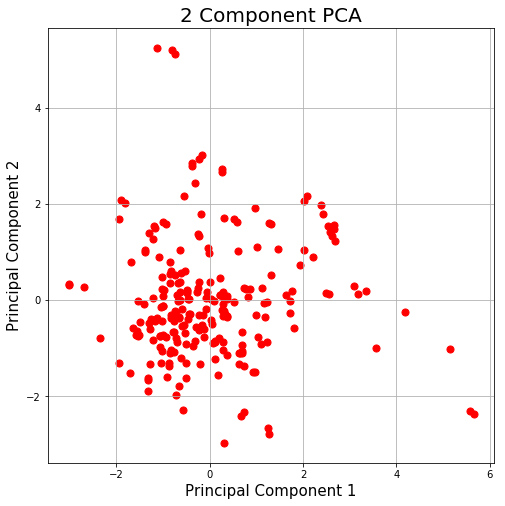

In [58]:
# we can now visualize the data by plotting them

# finalDf is the final DataFrame before plotting the data (nothing great, just taking result of PCA and attaching target to it)
#finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

finalDf = principalDf # we don't have targets to show

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

ax.scatter(finalDf.loc[:, 'principal component 1']
          , finalDf.loc[:,'principal component 2']
          , c = 'r'
          , s = 50)

#targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
#colors = ['r', 'g', 'b']
#for target, color in zip(targets, colors):
#    indicesToKeep = finalDf['target'] == target
#    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#               , finalDf.loc[indicesToKeep, 'principal component 2']
#               , c = color
#               , s = 50)
#ax.legend(targets)
ax.grid()
print("Number of points shown ", len(finalDf))

